<a href="https://colab.research.google.com/github/LuisCGit/HipHopPopularity/blob/main/notebooks/LibrosaProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install varname
!pip install pydub
!pip install librosa

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from ast import literal_eval

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import IPython.display as ipd

import requests
import os
from varname import argname
from pydub import AudioSegment
import librosa
import librosa.display

import pickle

In [3]:
#!wget -O lp.pkl_n2k https://www.dropbox.com/s/cbyr3w2mcn8afds/lp.pkl_n2k?dl=0
# with open('lp.pkl_n2k', 'rb') as f:
#   lp = pickle.load(f)

# !wget -O lp3.pkl_n2k https://www.dropbox.com/s/my6z6u6l3b9wnce/lp3.pkl_n2k?dl=0
# with open('lp3.pkl_n2k', 'rb') as f:
#   lp3 = pickle.load(f)

# !wget -O mel_spec_datadict https://www.dropbox.com/s/nrebpbe5g97sptu/mel_spec_datadict?dl=0
# with open('mel_spec_datadict', 'rb') as f:
#   mel_spec_datadict = pickle.load(f)

!wget -O raw_datadict.pkl_n2k https://www.dropbox.com/s/51chsdgaro90px5/raw_datadict.pkl_n2k?dl=0
with open('mel_spec_datadict', 'rb') as f:
  raw_datadict = pickle.load(f)

--2022-05-01 16:29:37--  https://www.dropbox.com/s/51chsdgaro90px5/raw_datadict.pkl_n2k?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/51chsdgaro90px5/raw_datadict.pkl_n2k [following]
--2022-05-01 16:29:37--  https://www.dropbox.com/s/raw/51chsdgaro90px5/raw_datadict.pkl_n2k
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd06e6d8f46b9734a4c0c812fe8.dl.dropboxusercontent.com/cd/0/inline/Bkdn2XUIWBAh6w-CwN4OGPX1b-ZZudGycKgY8-TIANF9ALfzyQCjmrJd0Fl5nDhiBLF9zNajL4sPil6DMJfqdnusGpOTBL4ityQYEpNjWeW7pbDXyQqyZbqgNq2o3xcISb_T-fO9kwNrCf_0E0RBio596Ug0JXgbKWMZhrqzKUuqrQ/file# [following]
--2022-05-01 16:29:37--  https://ucd06e6d8f46b9734a4c0c812fe8.dl.dropboxusercontent.com/cd/0/inline/Bkdn2XUIWBAh6w-CwN4OGPX1b-ZZudGycKgY8-T

In [ ]:
raw_datadict["X_holdout"][0].head()

,id,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url,genre
19311,4Ox8WAAhq0BK02B62yP203,7 Tears,[Shark Island],Bloodline 2.020,album,2020-11-20,https://i.scdn.co/image/ab67616d0000b273951041...,330986,https://p.scdn.co/mp3-preview/7944d46e56d1a8b2...,Metal
25053,39TAKt2hL8sdhVTFCNfm2Y,Ai Đưa Em Về,"[TIA, Le Thien Hieu]",Ai Đưa Em Về,single,2019-07-22,https://i.scdn.co/image/ab67616d0000b273983b10...,233249,https://p.scdn.co/mp3-preview/411bea81d0fa9d1a...,Pop
28082,7fBy7U8Acr69muYNFhuZtg,5911,"[Miss Pooja, Gurvinder Brar]","Best Free Styles, Vol. 2",album,2020-07-18,https://i.scdn.co/image/ab67616d0000b27349a1c9...,242917,https://p.scdn.co/mp3-preview/c4043d3cbb6901c3...,Pop
3643,4LGBvq6TRWVIeZ7CFyGsEd,I Lied (Intro),[Joyner Lucas],ADHD,album,2020-03-27,https://i.scdn.co/image/ab67616d0000b273e7e2da...,251496,https://p.scdn.co/mp3-preview/33c4f5e9f34e5564...,Hip-Hop
16692,5q5VVhl2BL7Ms2tO6hdvFp,Built from War,[Upon A Burning Body],Built from War,single,2020-07-31,https://i.scdn.co/image/ab67616d0000b273dbfc6b...,204661,https://p.scdn.co/mp3-preview/f399cb5b2f16e6f7...,Metal


In [ ]:
mp3s = pd.read_csv('dataset1_mp3s.csv', index_col=0)

In [ ]:
mp3s['artists'] = mp3s['artists'].map(lambda x: literal_eval(x))

In [ ]:
mp3s[mp3s['track'] == "3 Headed Goat (feat. Lil Baby & Polo G)"]

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url,genre
763,6Tguhaf2uAe6OjRLsR2Tql,75,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b273f8558e...,169531,https://p.scdn.co/mp3-preview/2d01e3ab3d48b281...,Hip-Hop
2550,14c8arYQPMtxPcF4L4FYXC,45,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273fec5f2...,169531,https://p.scdn.co/mp3-preview/e2e7d8016dfba565...,Hip-Hop


In [ ]:
# there are duplicate songs from different albums (single, album, etc.)
# if they have different popularity scores, that's still valuable info, however
mp3s[mp3s.duplicated(subset=['track','duration_ms','popularity'], 
                     keep=False)]['track'].value_counts()

Distant Thinderstorm 700Hz with Thunder              9
8 Hours of Natural Rain Sounds                       8
Daft Punk Is Playing at My House                     7
Barber's Adagio for Strings - Ferry Corsten Remix    5
Let Me Know - Oscar the Punk Mix                     4
                                                    ..
Vanish Canvas                                        2
I Walked with a Zombie                               2
Fast Junkie                                          2
Jumpdafuckup                                         2
50/50 Love                                           2
Name: track, Length: 93, dtype: int64

In [ ]:
mp3s.shape

(23521, 11)

In [ ]:
mp3s.drop_duplicates(subset=['track','duration_ms','popularity'], inplace=True)
mp3s.shape

(23383, 11)

In [ ]:
# making train test holdout splits

X = mp3s.drop(columns=['popularity'])
y = mp3s['popularity']

X_pretr, X_holdout, y_pretr, y_holdout = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_pretr, y_pretr, 
                                                    test_size=15/90, random_state=42)
print(X_train.shape, X_test.shape, X_holdout.shape)

(17536, 10) (3508, 10) (2339, 10)


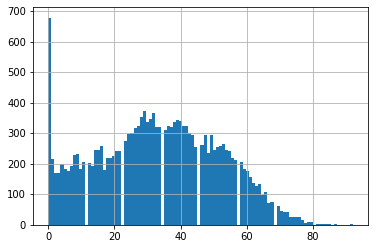

In [ ]:
# 39 seems to be a good cutoff
y_train.hist(bins=100)

In [ ]:
# defining popular as >= 39 and encoding (1 = popular)
y_train = y_train.map(lambda x: 1 if x >= 39 else 0)
y_train.value_counts(normalize=True)

0    0.600023
1    0.399977
Name: popularity, dtype: float64

In [ ]:
y_test = y_test.map(lambda x: 1 if x >= 39 else 0)
y_test.value_counts(normalize=True)

0    0.61146
1    0.38854
Name: popularity, dtype: float64

In [ ]:
y_holdout = y_holdout.map(lambda x: 1 if x >= 39 else 0)
y_holdout.value_counts(normalize=True)

0    0.613083
1    0.386917
Name: popularity, dtype: float64

In [7]:
def get_mp3(http, directory, name):
    try:
        r = requests.get(http, timeout=2)
        with open(f'{directory}/{name}.mp3', 'wb') as f:
            f.write(r.content)
        print(f'mp3 acquision: {name}.mp3')
    except:
        print(f'mp3 timeout: index {name}')

In [6]:
class LibrosaProcessing:
    def __init__(self, split, data, target):
        self.data_ = data.copy()
        self.target_ = target.copy()
        wd = !pwd
        self.directory_ = f'{wd[0]}/data/{split}'
        print("wd[0]: ", wd[0])
        if not os.path.exists(self.directory_):
            os.mkdir(self.directory_)
        self.mp3_directory_ = f'{self.directory_}/mp3'
        self.wav_directory_ = f'{self.directory_}/wav'

    def get_mp3(self):
        if not os.path.exists(self.mp3_directory_):
            os.mkdir(self.mp3_directory_)
        self.data_['preview_url'].reset_index().apply(lambda x: get_mp3(x[1],
                                                                         self.mp3_directory_,
                                                                         x[0]), axis=1)
        print('mp3s acquired')
        
    def get_wav(self):
        if not os.path.exists(self.wav_directory_):
            os.mkdir(self.wav_directory_)
        for file in os.listdir(self.mp3_directory_):
            src = f'{self.mp3_directory_}/{file}'
            dest = f'{self.wav_directory_}/{file.split(".")[0]}.wav'
            AudioSegment.from_mp3(src).export(dest, format='wav')
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = dest
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()
    
    def get_wav_path(self):
        for file in os.listdir(self.wav_directory_):
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = f'{self.wav_directory_}/{file}'
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()

    def get_mel_spec(self):
        self.specs_pre_ = []
        self.spaxmax1_ = 128 # max size in dimension 1 for X_train
        self.spaxmax2_ = 1292 # max size in dimension 2 for X_train
        for count, song in enumerate(self.wav_, start=1):
            y, sr = librosa.load(song, duration=30)
            spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y,sr=sr), ref=np.min)
            self.specs_pre_.append(spec[np.newaxis, ..., np.newaxis])
            print(f"wavs run: {count}/{len(self.wav_)}")
        resized = []
        for spec in self.specs_pre_:
            resized.append(np.resize(spec, (1, self.spaxmax1_, self.spaxmax2_, 1)))
        self.mel_specs_ = np.concatenate(resized, axis=0)
        return (self.mel_specs_, self.target_)
    
    def get_mfcc(self):
        pass
#         librosa.        
#         return 

In [ ]:
n = 2000
X_train_small = X_train.iloc[:n,:];  y_train_small = y_train[:n]
X_test_small = X_test.iloc[:n,:]; y_test_small = y_test[:n]
X_holdout_small = X_holdout.iloc[:n,:]; y_holdout_small = y_holdout[:n]
raw_datadict = {'X_train': (X_train_small, y_train_small), 
            'X_test': (X_test_small, y_test_small),
            'X_holdout': (X_holdout_small, y_holdout_small)}

In [ ]:
X_train_small.shape

(2000, 10)

In [ ]:
with open('mel_spec_dict.pkl', 'rb') as up:
    mel_spec_datadict = pickle.load(up)

FileNotFoundError: ignored

In [ ]:
mel_spec_datadict.keys()

NameError: ignored

In [ ]:
raw_datadict["X_train"][2].shape

IndexError: ignored

In [ ]:
np.all(np.array(list(map(lambda x: len(x), X_train_small["preview_url"])))==107)

True

In [ ]:
with open('raw_datadict.pkl', 'wb') as f:
  pickle.dump(raw_datadict, f)

In [ ]:
raw_datadict['X_train'][1]

8664     1
4063     0
27400    1
23839    0
9312     1
        ..
24021    0
29212    1
2499     1
13528    0
9765     0
Name: popularity, Length: 2000, dtype: int64

In [4]:
# mel_spec_datadict = {}
# for i, (split, info) in enumerate(raw_datadict.items()):
#     if split == 'X_train':
#         lp = LibrosaProcessing(split, info[0], info[1])
#         lp.get_mp3()
#         lp.get_wav()
#         mel_spec_datadict[split] = lp.get_mel_spec()
#     if split == 'X_test':
#         lp2 = LibrosaProcessing(split, info[0], info[1])
#         lp2.get_mp3()
#         lp2.get_wav()
#         mel_spec_datadict[split] = lp2.get_mel_spec()
#     if split == 'X_holdout':
#         lp3 = LibrosaProcessing(split, info[0], info[1])
#         lp3.get_mp3()
#         lp3.get_wav()
#         mel_spec_datadict[split] = lp3.get_mel_spec()

In [ ]:
# with open("drive/MyDrive/MIT/mel_spec_datadict", "wb") as f:
#   pickle.dump(mel_spec_datadict, f)

# with open('drive/MyDrive/MIT/lp.pkl_n2k', 'wb') as p:
#     pickle.dump(lp, p)
# with open('drive/MyDrive/MIT/lp2.pkl_n2k', 'wb') as p:
#     pickle.dump(lp2, p)
# with open('drive/MyDrive/MIT/lp3.pkl_n2k', 'wb') as p:
#   pickle.dump(lp3, p) 
with open('drive/MyDrive/MIT/raw_datadict.pkl_n2k', 'wb') as p:
    pickle.dump(raw_datadict, p)

In [ ]:
! pwd

/content


In [ ]:
# with open('mel_spec_dict_n2k.pkl', 'wb') as p:
#     pickle.dump(mel_spec_datadict, p)
# with open('lp.pkl_n2k', 'wb') as p:
#     pickle.dump(lp, p)
# with open('lp2.pkl_n2k', 'wb') as p:
#     pickle.dump(lp2, p)
# with open('lp3.pkl_n2k', 'wb') as p:
#   pickle.dump(lp3, p)
# with open('raw_datadict.pkl_n2k', 'wb') as p:
#     pickle.dump(lp, p)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


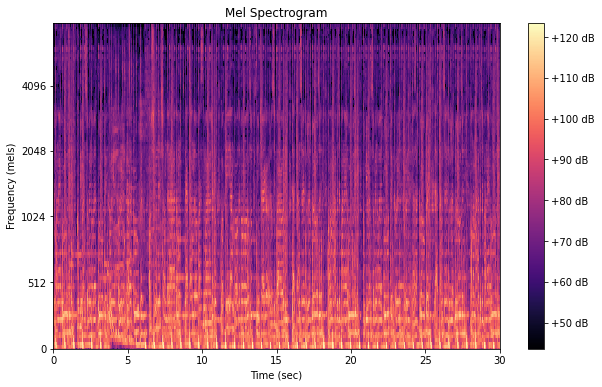

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
idx = 90
img = librosa.display.specshow(lp.specs_pre_[idx][0,:,:,0], x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

In [10]:
lp.specs_pre_[idx].shape

(1, 128, 1292, 1)

In [ ]:
y, sr = librosa.load(lp.wav_.iloc[0],duration=30)
ipd.Audio(y,rate=sr)

In [ ]:
class MinMaxScaler:
    def fit(self, X_train):
        self.X_train_ = X_train
        self.max_ = self.X_train_.max()
        self.min_ = self.X_train_.min()
        
    def transform(self, X):
        return (X - self.min_) / (self.max_ - self.min_)
        

In [ ]:
# Scaling
mm = MinMaxScaler()
mm.fit(mel_spec_datadict['X_train'][0])

mel_spec_sc = {}
for split, info in mel_spec_datadict.items():
    scaledX = mm.transform(info[0])
    mel_spec_sc[split] = (scaledX, info[1])


NameError: ignored

In [ ]:
with open('mel_spec_sc.pkl', 'wb') as p:
    pickle.dump(mel_spec_sc, p)